### import modules

In [1]:
import cv2
import glob
import copy
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Convolution1D, Dropout
from keras.optimizers import SGD
from keras.utils import np_utils

/Users/sakasaikeisuke/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/sakasaikeisuke/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/sakasaikeisuke/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np

### input data

In [3]:
train_data = pd.read_csv('../input/train.csv')
test_data = pd.read_csv('../input/test.csv')
train = train_data[['id', 'species']]
test = test_data[['id']]

### データの前処理

In [4]:
def resize_img(img=np.array([]), end_size=100, show=False):
    max_ = np.maximum(img.shape[0], img.shape[1])
    scale = end_size / max_
    height, width = img.shape
    size = (int(width * scale), int(height * scale))

    rescale_img = cv2.resize(img, size, interpolation=cv2.INTER_CUBIC)
    height, width = rescale_img.shape

    if width > height:
        z_padding = np.zeros([int((width - height) / 2), width], dtype=np.uint8)
        resize_img = np.vstack((z_padding, rescale_img, z_padding))
    else:
        z_padding = np.zeros([height, int((height - width) / 2)], dtype=np.uint8)
        resize_img = np.hstack((z_padding, rescale_img, z_padding))

    resize_img = cv2.resize(resize_img, (end_size, end_size))
    resize_img2 = resize_img.reshape(-1,)

    if show == True: return resize_img
    else:

        return resize_img2

In [5]:
# label_speacies の作成
all_label_list = train['species'].values
i = 0
label_species = {}
for label in all_label_list:
    if label in label_species: pass
    else:
        label_species['{}'.format(label)] = i
        i = i + 1
# label_species

In [6]:
end_size = 150
# x_train の作成
x_train = []
for _id in train['id']:
    img = np.array(Image.open('../input/images/{:.0f}.jpg'.format(_id)))
    x_train.append(resize_img(img, end_size=end_size))
x_train = np.array(x_train)

In [7]:
# x_test の作成
x_test = []
for _id in test['id']:
    img = np.array(Image.open('../input/images/{:.0f}.jpg'.format(_id)))
    x_test.append(resize_img(img, end_size=end_size))
x_test = np.array(x_test)

In [8]:
# t_train の作成
t_train = []
for _species in train['species']:
    _t_train = np.array([0] * 99)
    correct_label = label_species[_species]
    _t_train[correct_label] = 1
    t_train.append(_t_train)
t_train = np.array(t_train)

In [9]:
scaler = StandardScaler().fit(x_train)
scaled_train = scaler.transform(x_train)

/Users/sakasaikeisuke/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [10]:
label_encoder = LabelEncoder().fit(train.species)
labels = label_encoder.transform(train.species)
classes = list(label_encoder.classes_)
nb_class = len(classes)

### Cross validation

In [11]:
sss = StratifiedShuffleSplit(test_size=0.2, random_state=23)
for train_index, valid_index in sss.split(scaled_train, labels):
    X_train, X_valid = scaled_train[train_index], scaled_train[valid_index]
    y_train, y_valid = labels[train_index], labels[valid_index]
y_train = np_utils.to_categorical(y_train, nb_class)
y_valid = np_utils.to_categorical(y_valid, nb_class)

### MLP の作成

In [12]:
model = Sequential()
model.add(Dense(end_size ** 2, activation='relu'))
model.add(Dense(2048, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(nb_class))
model.add(Activation('softmax'))

W0827 18:42:03.623873 4445685184 deprecation_wrapper.py:119] From /Users/sakasaikeisuke/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



In [13]:
sgd = SGD(lr=0.01, nesterov=True, decay=1e-6, momentum=0.9)
model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])

W0827 18:42:05.816502 4445685184 deprecation_wrapper.py:119] From /Users/sakasaikeisuke/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



### 学習

In [ ]:
nb_epoch = 15
model.fit(X_train, y_train, nb_epoch=nb_epoch, validation_data=(X_valid, y_valid), batch_size=32)

/Users/sakasaikeisuke/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  
W0827 18:42:08.724367 4445685184 deprecation_wrapper.py:119] From /Users/sakasaikeisuke/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0827 18:42:08.728785 4445685184 deprecation_wrapper.py:119] From /Users/sakasaikeisuke/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0827 18:42:08.838438 4445685184 deprecation_wrapper.py:119] From /Users/sakasaikeisuke/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3576: The name tf.log is deprecated. Please use tf.math.log instead.

W0827 18:42:09.029

Train on 792 samples, validate on 198 samples
Epoch 1/15
192/792 [======>.......................] - ETA: 3:31 - loss: 4.5529 - acc: 0.1094 

### 可視化

Text(0.5,1,'Dense-1dimention')

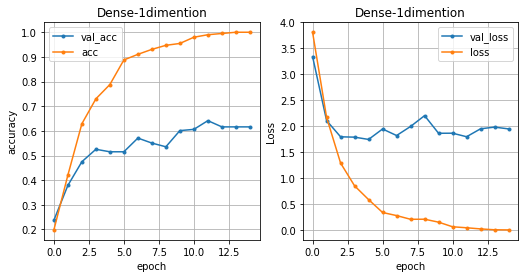

In [17]:
history = model.history
epoch = history.epoch
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']
acc = history.history['acc']
loss = history.history['loss']

fig= plt.figure(figsize=(8.5, 4))
ax, ax_ = fig.add_subplot(121), fig.add_subplot(122)

# ax.plot([epoch[0], epoch[-1]] , [1, 1], 'k', ls='dashed', alpha=0.5)
ax.plot(epoch, val_acc, '.-', label='val_acc')
ax.plot(epoch, acc, '.-', label='acc')
ax_.plot(epoch, val_loss, '.-', label='val_loss')
ax_.plot(epoch, loss, '.-', label='loss')

ax.grid()
ax.legend()
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
ax.set_title('Dense-1dimention')

ax_.grid()
ax_.legend()
ax_.set_xlabel('epoch')
ax_.set_ylabel('Loss')
ax_.set_title('Dense-1dimention')

### predict

In [18]:
t_test = model.predict(x_test)

---
id = 1376
label = Acer_Platanoids


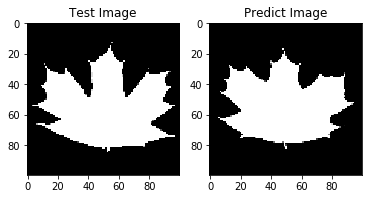

---
id = 903
label = Fagus_Sylvatica


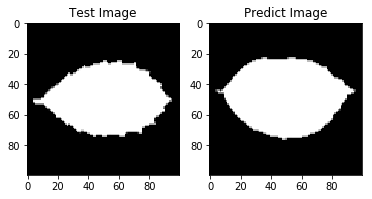

---
id = 181
label = Fagus_Sylvatica


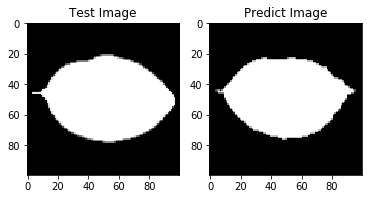

---
id = 1212
label = Populus_Nigra


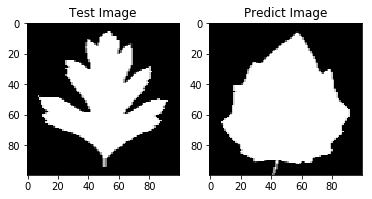

---
id = 1579
label = Viburnum_x_Rhytidophylloides


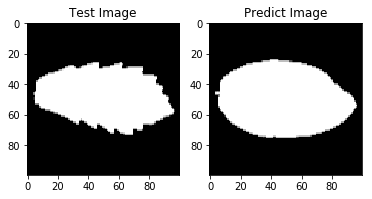

In [19]:
def show_png(label=''):
    x_id = train['id'].values
    x_species = train['species'].values
    x_classes_idx = np.array([x_id[i] for i, _ in enumerate(x_species) if _ == label])[0]
    img = Image.open('../input/images/{:.0f}.jpg'.format(x_classes_idx))
    
    return img

def predict_png(idx=0):
    t_id_test = test['id'].values
    t_idx = np.argmax(t_test[idx])
    t_label = classes[t_idx]
    t_id = t_id_test[idx]
    img = Image.open('../input/images/{:.0f}.jpg'.format(t_id))
    
    print('id = ' + str(t_id))
    print('label = ' + t_label)
    
    fig = plt.figure()
    ax1, ax2 = fig.add_subplot(121), fig.add_subplot(122)   
    ax1.imshow(resize_img(np.array(img), end_size=100, show=True), 'gray')
    ax1.set_title('Test Image')    
    ax2.imshow(resize_img(np.array(show_png(t_label)), end_size=100, show=True), 'gray')
    ax2.set_title('Predict Image') 
    
    plt.show()

for idx in np.random.choice(594, 5):
    print('---')
    predict_png(idx)

### submission

In [51]:
submission = pd.DataFrame()
submission['id'] = test['id']
for i, label in enumerate(label_species.keys()):
    submission[label] = t_test[:,i]

In [52]:
submission

,id,Acer_Opalus,Pterocarya_Stenoptera,Quercus_Hartwissiana,Tilia_Tomentosa,Quercus_Variabilis,Magnolia_Salicifolia,Quercus_Canariensis,Quercus_Rubra,Quercus_Brantii,...,Quercus_Ellipsoidalis,Quercus_x_Hispanica,Quercus_Shumardii,Quercus_Rhysophylla,Castanea_Sativa,Ulmus_Bergmanniana,Quercus_Nigra,Salix_Intergra,Quercus_Infectoria_sub,Sorbus_Aria
0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,16,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,19,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.820983e-31,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
submission.to_csv('./submission.csv', index=False)